In [1]:
# https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html#prepare-notebook

In [2]:
#Columns req
# units_sold
# price
# oos
# events,
# branded_clicks
# branded_spends,
# nonbranded_clicks
# nonbranded_spends,
# insta_clicks
# insta_spends
# fb_clicks
# fb_spends

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [2]:
# product outline
products = {
    'premium': 80,
    'mid_tier': 30,
    'low_tier': 20
}

In [3]:
# Date outline
dates = pd.date_range(start='2025-06-11', periods=104, freq='W-SAT')  # 2 years of weekly data
n_weeks = len(dates)
n_weeks

104

In [4]:
#date outline
min_date = pd.to_datetime("2023-01-01")
max_date = pd.to_datetime("2025-01-01")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-SAT")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]
print(f"Number of observations: {n}")
df.head()

Number of observations: 104


,date_week,year,month,dayofyear
0,2023-01-07,2023,1,7
1,2023-01-14,2023,1,14
2,2023-01-21,2023,1,21
3,2023-01-28,2023,1,28
4,2023-02-04,2023,2,35


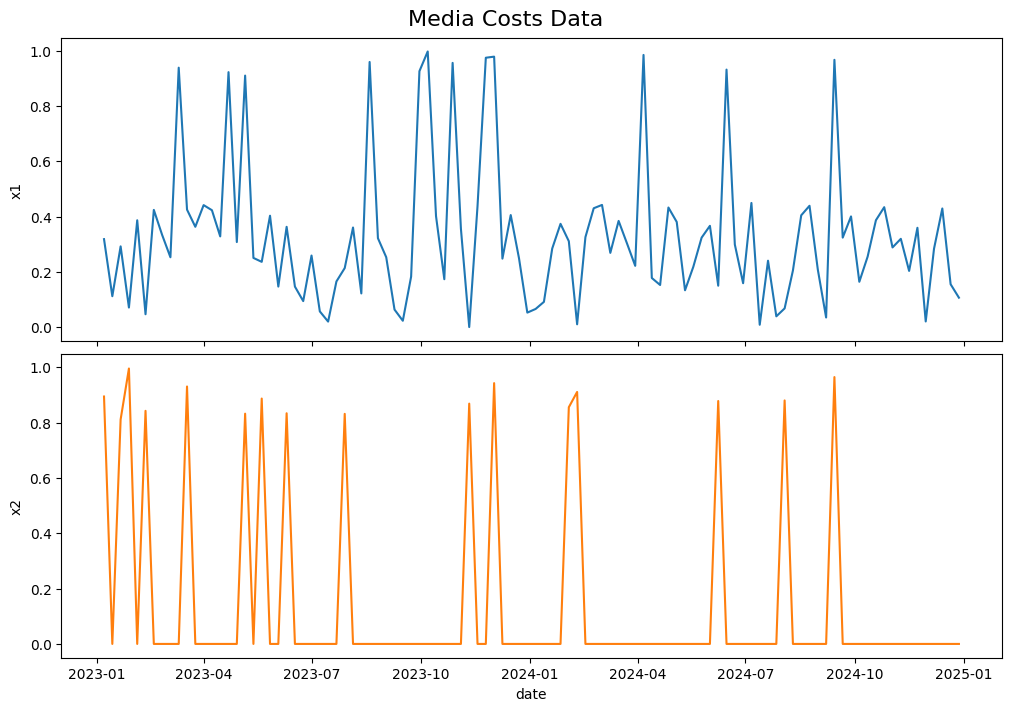

In [5]:
# media data
x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = np.where(x2 > 0.8, x2, 0)


fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);

In [6]:
# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2

df["x1_adstock"] = (
    geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["x2_adstock"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
    .eval()
    .flatten()
)

In [7]:
# apply saturation transformation
lam1: float = 4.0
lam2: float = 3.0

df["x1_adstock_saturated"] = logistic_saturation(
    x=df["x1_adstock"].to_numpy(), lam=lam1
).eval()

df["x2_adstock_saturated"] = logistic_saturation(
    x=df["x2_adstock"].to_numpy(), lam=lam2
).eval()

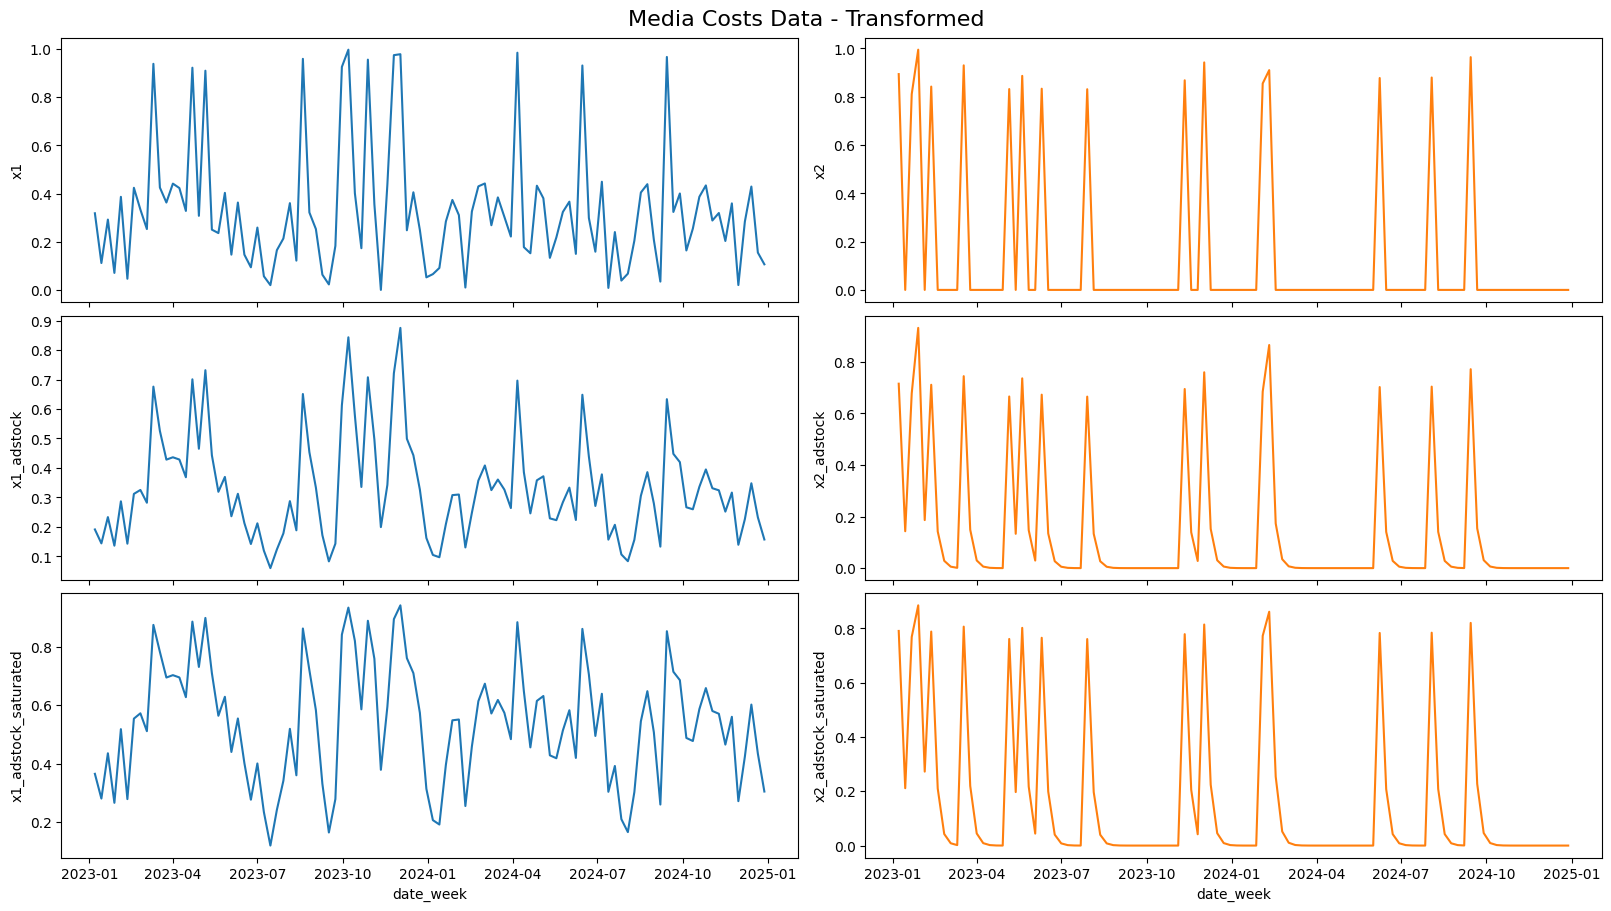

In [8]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="x1_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="x2_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="x1_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="x2_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16);

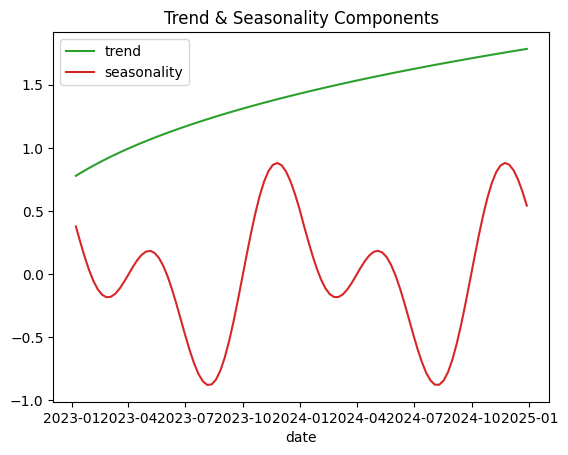

In [9]:
# Trend & Seasonal Components

df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="trend", color="C2", label="trend", data=df, ax=ax)
sns.lineplot(
    x="date_week", y="seasonality", color="C3", label="seasonality", data=df, ax=ax
)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None);

In [ ]:
#Columns req
# units_sold
# price
# oos
# events,
# branded_clicks
# branded_spends,
# nonbranded_clicks
# nonbranded_spends,
# insta_clicks
# insta_spends
# fb_clicks
# fb_spends